In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo, list_available_datasets

In [4]:
# import pandas as pd
# dataset_id = {
#     "heart_disease" : 145,
#     "chronic_kidney_disease" : 336,
#     "risk_factor_prediction_ckd" : 857,
#     "breast_cancer" : 451,
#     "diabetes_usa" : 296,
#     "early_diabetes": 529,
#     "maternal_health_risk" : 863,
#     "liver" : 46,
#     "obesity" : 544
# }

# for name, id in dataset_id.items():
#     dataset = fetch_ucirepo(id=id)
#     df = dataset.data.original  # Use 'cleaned' if needed

#     # Save to CSV locally
#     filename = f"{name}.csv"
#     df.to_csv(filename, index=False)
#     print(f"Saved {name} dataset as {filename}")

In [3]:
!pip install azure-storage-blob pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.9/406.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 10.5 MB/s eta 0:00:00


In [4]:
from azure.storage.blob import BlobServiceClient
import pandas as pd
import io

In [ ]:
# Define your Azure Storage Account details
STORAGE_ACCOUNT_NAME = ""
STORAGE_ACCOUNT_KEY = ""
CONTAINER_NAME = ""

# Create a connection string
connection_string = f"DefaultEndpointsProtocol=https;AccountName={STORAGE_ACCOUNT_NAME};AccountKey={STORAGE_ACCOUNT_KEY};EndpointSuffix=core.windows.net"

# Connect to the blob service
blob_service_client = BlobServiceClient.from_connection_string(connection_string)


In [6]:
# List all blobs (files) in the container
container_client = blob_service_client.get_container_client(CONTAINER_NAME)
blob_list = container_client.list_blobs()

print("Files in Blob Storage:")
for blob in blob_list:
    print(blob.name)


Files in Blob Storage:
breast_cancer.csv
chronic_kidney_disease.csv
diabetes_usa.csv
early_diabetes.csv
heart_disease.csv
liver.csv
maternal_health_risk.csv
obesity.csv


## Breast Cancer

In [7]:
#breat cancer
blob_client = container_client.get_blob_client("breast_cancer.csv")

# Download blob data
downloaded_blob = blob_client.download_blob()
csv_data = downloaded_blob.readall()

# Convert to pandas DataFrame
df_breastCancer = pd.read_csv(io.StringIO(csv_data.decode('utf-8')))
print(df_breastCancer.head(10))


   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   48  23.500000       70    2.707  0.467409   8.8071     9.702400   7.99585   
1   83  20.690495       92    3.115  0.706897   8.8438     5.429285   4.06405   
2   82  23.124670       91    4.498  1.009651  17.9393    22.432040   9.27715   
3   68  21.367521       77    3.226  0.612725   9.8827     7.169560  12.76600   
4   86  21.111111       92    3.549  0.805386   6.6994     4.819240  10.57635   
5   49  22.854458       92    3.226  0.732087   6.8317    13.679750  10.31760   
6   89  22.700000       77    4.690  0.890787   6.9640     5.589865  12.93610   
7   76  23.800000      118    6.470  1.883201   4.3110    13.251320   5.10420   
8   73  22.000000       97    3.350  0.801543   4.4700    10.358725   6.28445   
9   75  23.000000       83    4.952  1.013839  17.1270    11.578990   7.09130   

      MCP.1  Classification  
0   417.114               1  
1   468.786               1  
2   554.697       

In [8]:
#checking nan values
print(df_breastCancer.isna().sum())

Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64


In [9]:
df_breastCancer.drop_duplicates(inplace=True)

## Checking the skewness and normalizing the data


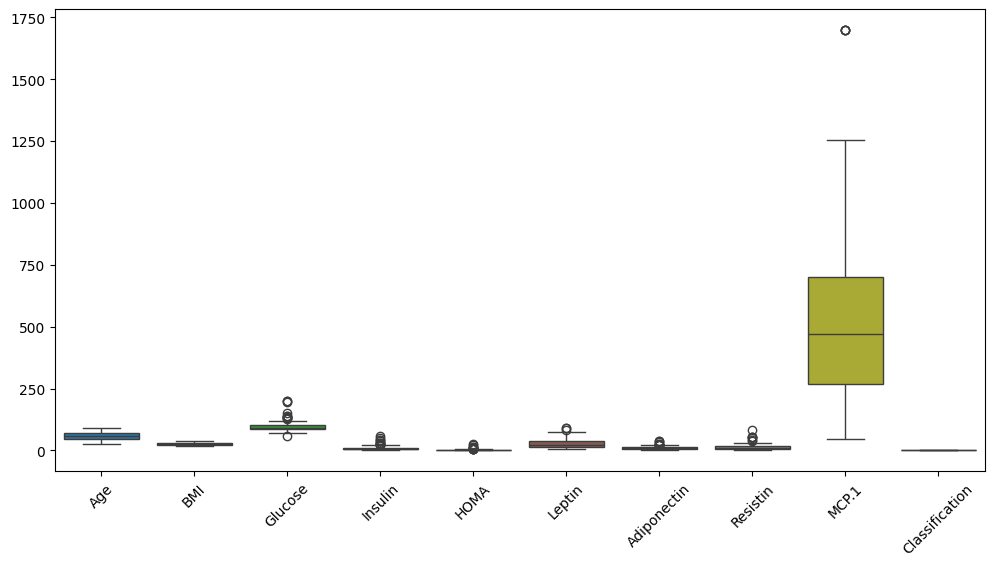

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_breastCancer)
plt.xticks(rotation=45)
plt.show()

In [11]:
#normalizing some features:
import numpy as np

df_breastCancer['MCP.1'] = np.log1p(df_breastCancer['MCP.1'])
df_breastCancer['Insulin'] = np.log1p(df_breastCancer['Insulin'])
print(df_breastCancer['MCP.1'])

0      6.035754
1      6.152277
2      6.320223
3      6.834346
4      6.652760
         ...   
111    5.595566
112    5.802602
113    5.752731
114    5.974979
115    4.511848
Name: MCP.1, Length: 116, dtype: float64


In [12]:
from scipy.stats import skew
print(df_breastCancer['MCP.1'].skew())

-0.5129520962079838


In [13]:
from scipy.stats import boxcox
df_breastCancer['MCP.1'], _ = boxcox(df_breastCancer['MCP.1'] + 1)

In [14]:
print(df_breastCancer['MCP.1'].skew())

-0.006831314822481881


In [16]:
print(df_breastCancer['Insulin'].skew())

0.08985001616072288


In [17]:
df_breastCancer['Insulin'], _ = boxcox(df_breastCancer['Insulin'] + 1)
print(df_breastCancer['Insulin'].skew())

0.006889301443425097


In [18]:
skew_values = df_breastCancer.skew().sort_values(ascending=False)
print(skew_values)

HOMA              3.812087
Glucose           2.593305
Resistin          2.577429
Adiponectin       1.817765
Leptin            1.309536
BMI               0.170152
Age               0.017832
Insulin           0.006889
MCP.1            -0.006831
Classification   -0.210748
dtype: float64


In [19]:
from scipy.stats import boxcox
import numpy as np

skewed_cols = ['Glucose', 'Leptin', 'HOMA', 'Adiponectin' , 'Resistin']

for col in skewed_cols:
    if (df_breastCancer[col] > 0).all():
        df_breastCancer[col], _ = boxcox(df_breastCancer[col])
    else:
        from sklearn.preprocessing import PowerTransformer
        pt = PowerTransformer(method='yeo-johnson')
        df_breastCancer[col] = pt.fit_transform(df_breastCancer[[col]])

print(df_breastCancer[skewed_cols].skew())


Glucose       -0.131235
Leptin         0.004261
HOMA           0.117326
Adiponectin   -0.000177
Resistin       0.023984
dtype: float64


In [20]:
from sklearn.model_selection import train_test_split

X = df_breastCancer.drop(columns=['Classification'])
y = df_breastCancer['Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
#baseline model with LR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {lr_accuracy:.4f}')

Logistic Regression Accuracy: 0.7241


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')

Decision Tree Accuracy: 0.4483


In [23]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

Random Forest Accuracy: 0.7586


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {gb_accuracy:.4f}')


Gradient Boosting Accuracy: 0.7241


In [25]:
importances = RF.feature_importances_
feature_names = X_train.columns
sorted(zip(importances, feature_names), reverse=True)

[(np.float64(0.20501846799201995), 'Glucose'),
 (np.float64(0.18218546473046418), 'Age'),
 (np.float64(0.10670387223439673), 'BMI'),
 (np.float64(0.09204744005632182), 'Adiponectin'),
 (np.float64(0.09136772284215494), 'Leptin'),
 (np.float64(0.0893283008309524), 'Resistin'),
 (np.float64(0.08805492903381373), 'HOMA'),
 (np.float64(0.07820617592321681), 'Insulin'),
 (np.float64(0.06708762635665934), 'MCP.1')]

In [67]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best accuracy:", grid_search.best_score_)


In [26]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {svm_accuracy:.4f}')

SVM Accuracy: 0.4828


<ipython-input-27-ce24e4527395>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])


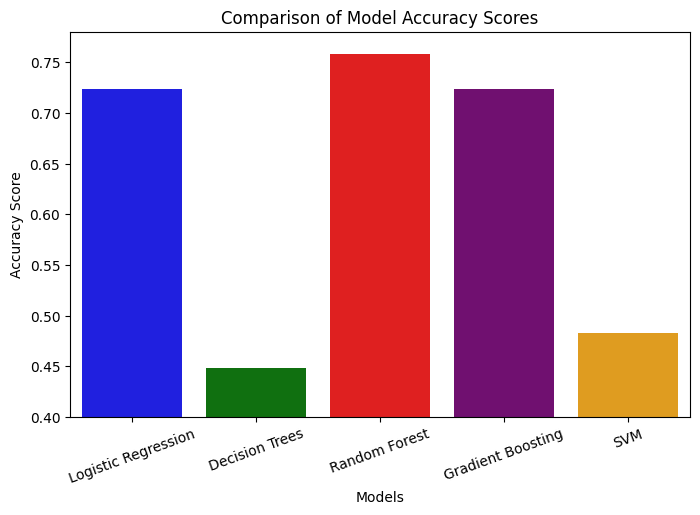

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Gradient Boosting', 'SVM']
accuracy_scores = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, svm_accuracy]  # Fixing duplicate values
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])

plt.ylim(0.4, 0.78)
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks(rotation=20)

plt.show()

##Kidney diseases

In [28]:
blob_client = container_client.get_blob_client("chronic_kidney_disease.csv")

# Download blob data
downloaded_blob_kidney = blob_client.download_blob()
csv_data_kidney = downloaded_blob_kidney.readall()

# Convert to pandas DataFrame
df_kidneydiseases = pd.read_csv(io.StringIO(csv_data_kidney.decode('utf-8')))
print(df_kidneydiseases.head(10))

    age     bp     sg   al   su       rbc        pc         pcc          ba  \
0  48.0   80.0  1.020  1.0  0.0       NaN    normal  notpresent  notpresent   
1   7.0   50.0  1.020  4.0  0.0       NaN    normal  notpresent  notpresent   
2  62.0   80.0  1.010  2.0  3.0    normal    normal  notpresent  notpresent   
3  48.0   70.0  1.005  4.0  0.0    normal  abnormal     present  notpresent   
4  51.0   80.0  1.010  2.0  0.0    normal    normal  notpresent  notpresent   
5  60.0   90.0  1.015  3.0  0.0       NaN       NaN  notpresent  notpresent   
6  68.0   70.0  1.010  0.0  0.0       NaN    normal  notpresent  notpresent   
7  24.0    NaN  1.015  2.0  4.0    normal  abnormal  notpresent  notpresent   
8  52.0  100.0  1.015  3.0  0.0    normal  abnormal     present  notpresent   
9  53.0   90.0  1.020  2.0  0.0  abnormal  abnormal     present  notpresent   

     bgr  ...   pcv     wbcc  rbcc  htn   dm  cad  appet   pe  ane class  
0  121.0  ...  44.0   7800.0   5.2  yes  yes   no   goo

In [29]:
print(df_kidneydiseases.isna().sum())

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64


In [30]:
# Filling numerical columns with the mean
num_cols = ['age', 'bp', 'sg' , 'al' , 'su' , 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
df_kidneydiseases[num_cols] = df_kidneydiseases[num_cols].fillna(df_kidneydiseases[num_cols].mean())

# Filling categorical columns with the mode (most frequent value)
cat_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
df_kidneydiseases[cat_cols] = df_kidneydiseases[cat_cols].fillna(df_kidneydiseases[cat_cols].mode().iloc[0])

In [31]:
print(df_kidneydiseases.isna().sum())

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64


In [32]:
#checking the skewness
df_skew = df_kidneydiseases.select_dtypes(include=['number'])
skew_values_kidney = df_skew.skew().sort_values(ascending=False)
print(skew_values_kidney)

pot     13.101157
sc       7.673105
bu       2.698754
su       2.629266
bgr      2.130422
wbcc     1.888887
bp       1.629876
al       1.060509
sg      -0.183473
rbcc    -0.223145
hemo    -0.359057
pcv     -0.477800
age     -0.675848
sod     -7.901094
dtype: float64


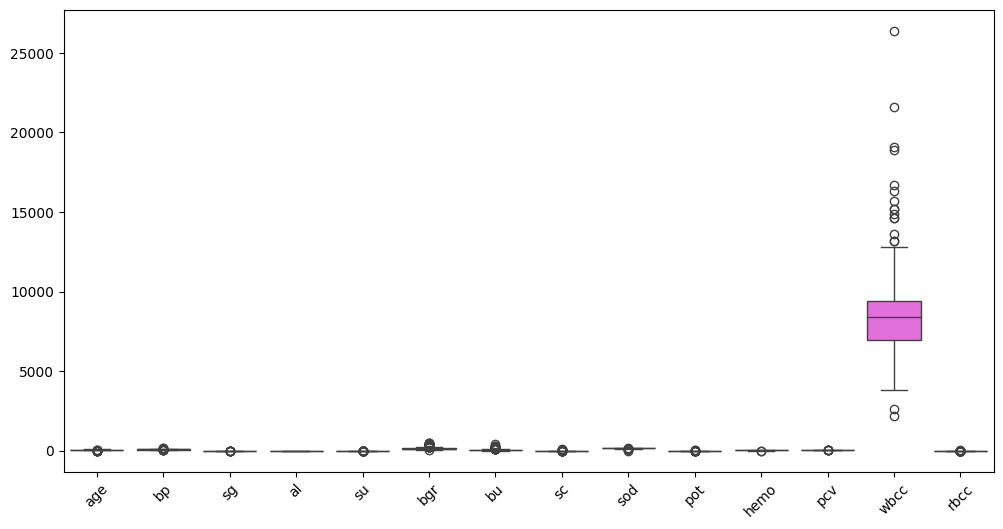

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_kidneydiseases)
plt.xticks(rotation=45)
plt.show()

In [34]:
kidney_skewed_cols = ['age', 'bp', 'sg' , 'al' , 'su' , 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']

for col in kidney_skewed_cols:
    if (df_kidneydiseases[col] > 0).all():
        df_kidneydiseases[col], _ = boxcox(df_kidneydiseases[col])
    else:
        from sklearn.preprocessing import PowerTransformer
        pt = PowerTransformer(method='yeo-johnson')
        df_kidneydiseases[col] = pt.fit_transform(df_kidneydiseases[[col]])

print(df_kidneydiseases[kidney_skewed_cols].skew())

age    -0.233243
bp     -0.018854
sg     -0.032458
al      0.248978
su      1.105646
bgr    -0.134214
bu     -0.025444
sc      0.100012
sod     0.091238
pot    -0.395817
hemo   -0.058426
pcv    -0.050693
wbcc    0.036590
rbcc    0.070667
dtype: float64


In [35]:
df_kidneydiseases['su'] = np.log1p(df_kidneydiseases['su'])
print(df_kidneydiseases['su'].skew())

1.0321124188823934


In [36]:
# cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'] rbc_normal

df_kidneydiseases = pd.get_dummies(df_kidneydiseases, columns=['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], drop_first=True)

In [37]:
print(df_kidneydiseases.dtypes)

age            float64
bp             float64
sg             float64
al             float64
su             float64
bgr            float64
bu             float64
sc             float64
sod            float64
pot            float64
hemo           float64
pcv            float64
wbcc           float64
rbcc           float64
class           object
rbc_normal        bool
pc_normal         bool
pcc_present       bool
ba_present        bool
htn_yes           bool
dm_no             bool
dm_yes            bool
cad_yes           bool
appet_poor        bool
pe_yes            bool
ane_yes           bool
dtype: object


In [38]:
X = df_kidneydiseases.drop(columns=['class'])
y = df_kidneydiseases['class']

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [40]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Accuracy:", lr_accuracy)

Logistic Regression Accuracy: 0.65


In [41]:
# decision trees
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')

Decision Tree Accuracy: 0.9800


In [42]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')


Random Forest Accuracy: 1.0000


In [43]:
#svm
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {svm_accuracy:.4f}')

SVM Accuracy: 0.7800


<ipython-input-274-acdf52f34dbb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])


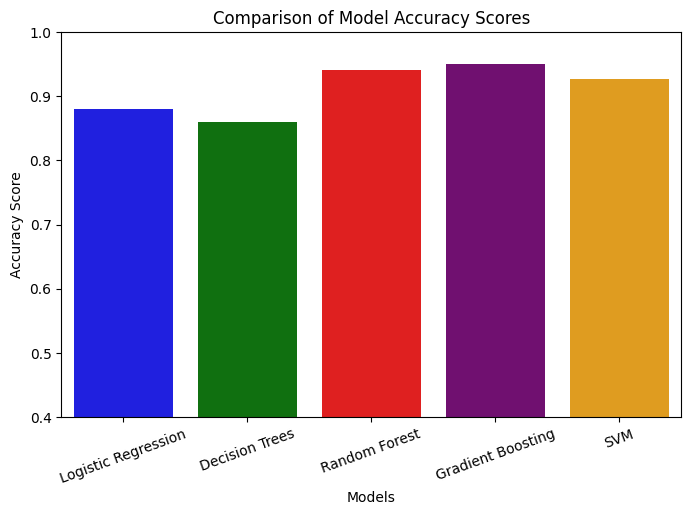

In [274]:
models = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Gradient Boosting', 'SVM']
accuracy_scores = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, svm_accuracy]  # Fixing duplicate values
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])

plt.ylim(0.4, 1.0)
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks(rotation=20)

plt.show()

## Diabetes

### Dropping this dataset since the entire weight column has nan values

In [44]:
# blob_client = container_client.get_blob_client("diabetes_usa.csv")

# # Download blob data
# downloaded_blob_diabetes = blob_client.download_blob()
# csv_data_diabetes = downloaded_blob_diabetes.readall()

# # Convert to pandas DataFrame
# df_diabetes = pd.read_csv(io.StringIO(csv_data_diabetes.decode('utf-8')))
# print(df_diabetes.head(10))

<ipython-input-44-3f21665fbad6>:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_diabetes = pd.read_csv(io.StringIO(csv_data_diabetes.decode('utf-8')))


   encounter_id  patient_nbr             race  gender       age weight  \
0       2278392      8222157        Caucasian  Female    [0-10)    NaN   
1        149190     55629189        Caucasian  Female   [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female   [20-30)    NaN   
3        500364     82442376        Caucasian    Male   [30-40)    NaN   
4         16680     42519267        Caucasian    Male   [40-50)    NaN   
5         35754     82637451        Caucasian    Male   [50-60)    NaN   
6         55842     84259809        Caucasian    Male   [60-70)    NaN   
7         63768    114882984        Caucasian    Male   [70-80)    NaN   
8         12522     48330783        Caucasian  Female   [80-90)    NaN   
9         15738     63555939        Caucasian  Female  [90-100)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                       

In [45]:
# print(df_diabetes.isna().sum())

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [46]:
# df_diabetes['race'].fillna(df_diabetes['race'].mode()[0], inplace=True)
# df_diabetes['medical_specialty'].fillna('Unknown', inplace=True)

<ipython-input-46-5b66b93572c1>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_diabetes['race'].fillna(df_diabetes['race'].mode()[0], inplace=True)
<ipython-input-46-5b66b93572c1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

In [50]:
# df_diabetes['weight'] = pd.to_numeric(df_diabetes['weight'], errors='coerce')
# df_diabetes['weight'].fillna(df_diabetes['weight'].median(), inplace=True)

<ipython-input-50-5141bc9107b4>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_diabetes['weight'].fillna(df_diabetes['weight'].median(), inplace=True)


In [53]:
# df_diabetes['max_glu_serum'] = pd.to_numeric(df_diabetes['max_glu_serum'], errors='coerce')
# df_diabetes['max_glu_serum'].fillna(df_diabetes['max_glu_serum'].median(), inplace=True)

<ipython-input-53-1c06207439e5>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_diabetes['max_glu_serum'].fillna(df_diabetes['max_glu_serum'].median(), inplace=True)


In [54]:
# df_diabetes['A1Cresult'] = pd.to_numeric(df_diabetes['A1Cresult'], errors='coerce')
# df_diabetes['A1Cresult'].fillna(df_diabetes['A1Cresult'].median(), inplace=True)

<ipython-input-54-c3ddc8131b2a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_diabetes['A1Cresult'].fillna(df_diabetes['A1Cresult'].median(), inplace=True)


In [55]:
# df_diabetes['weight'].fillna(df_diabetes['weight'].median(), inplace=True)
# df_diabetes['max_glu_serum'].fillna(df_diabetes['max_glu_serum'].median(), inplace=True)
# df_diabetes['A1Cresult'].fillna(df_diabetes['A1Cresult'].median(), inplace=True)

<ipython-input-55-419a652f3db9>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_diabetes['weight'].fillna(df_diabetes['weight'].median(), inplace=True)
<ipython-input-55-419a652f3db9>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [56]:
# df_diabetes = pd.get_dummies(df_diabetes, columns=['race', 'age', 'insulin'], drop_first=True)

In [57]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# num_cols = ['weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
#             'time_in_hospital', 'num_lab_procedures', 'num_procedures',
#             'num_medications', 'number_outpatient', 'number_emergency',
#             'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult']

# df_diabetes[num_cols] = scaler.fit_transform(df_diabetes[num_cols])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [59]:
# print(df_diabetes.isna().sum())  # No missing values should remain

encounter_id              0
patient_nbr               0
gender                    0
weight               101766
admission_type_id         0
                      ...  
age_[80-90)               0
age_[90-100)              0
insulin_No                0
insulin_Steady            0
insulin_Up                0
Length: 63, dtype: int64


In [60]:
# print(df_diabetes['weight'].unique())
# print(df_diabetes['weight'].dtype)

[nan]
float64


In [62]:
# #df_diabetes.shape
# df_diabetes.drop(columns=['weight'],inplace=True)

## Using this dataset instead

In [103]:
blob_client = container_client.get_blob_client("early_diabetes.csv")

# Download blob data
downloaded_blob_diabetes_early = blob_client.download_blob()
csv_data_diabetes_early = downloaded_blob_diabetes_early.readall()

# Convert to pandas DataFrame
df_diabetes_early = pd.read_csv(io.StringIO(csv_data_diabetes_early.decode('utf-8')))
print(df_diabetes_early.head(10))

   age gender polyuria polydipsia sudden_weight_loss weakness polyphagia  \
0   40   Male       No        Yes                 No      Yes         No   
1   58   Male       No         No                 No      Yes         No   
2   41   Male      Yes         No                 No      Yes        Yes   
3   45   Male       No         No                Yes      Yes        Yes   
4   60   Male      Yes        Yes                Yes      Yes        Yes   
5   55   Male      Yes        Yes                 No      Yes        Yes   
6   57   Male      Yes        Yes                 No      Yes        Yes   
7   66   Male      Yes        Yes                Yes      Yes         No   
8   67   Male      Yes        Yes                 No      Yes        Yes   
9   70   Male       No        Yes                Yes      Yes        Yes   

  genital_thrush visual_blurring itching irritability delayed_healing  \
0             No              No     Yes           No             Yes   
1             No 

In [104]:
print(df_diabetes_early.isna().sum())

age                   0
gender                0
polyuria              0
polydipsia            0
sudden_weight_loss    0
weakness              0
polyphagia            0
genital_thrush        0
visual_blurring       0
itching               0
irritability          0
delayed_healing       0
partial_paresis       0
muscle_stiffness      0
alopecia              0
obesity               0
class                 0
dtype: int64


In [105]:
df_diabetes_early = pd.get_dummies(df_diabetes_early, drop_first=True).astype(int)

In [107]:
df_diabetes_early.columns = df_diabetes_early.columns.str.replace('_Yes', '')
df_diabetes_early.columns = df_diabetes_early.columns.str.replace('_Male', '')
df_diabetes_early.columns = df_diabetes_early.columns.str.replace('_Positive', '')

In [108]:
df_diabetes_early.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [112]:
df_skew = df_diabetes_early.select_dtypes(include=['number'])
skew_values_diabetes = df_skew.skew().sort_values(ascending=False)
print(skew_values_diabetes)

obesity               1.769420
genital_thrush        1.334223
irritability          1.206305
alopecia              0.657608
muscle_stiffness      0.517893
sudden_weight_loss    0.336359
age                   0.329359
partial_paresis       0.280426
visual_blurring       0.209426
polydipsia            0.209426
polyphagia            0.178134
delayed_healing       0.162537
itching               0.054022
polyuria              0.015430
weakness             -0.352476
class                -0.475715
gender               -0.543509
dtype: float64


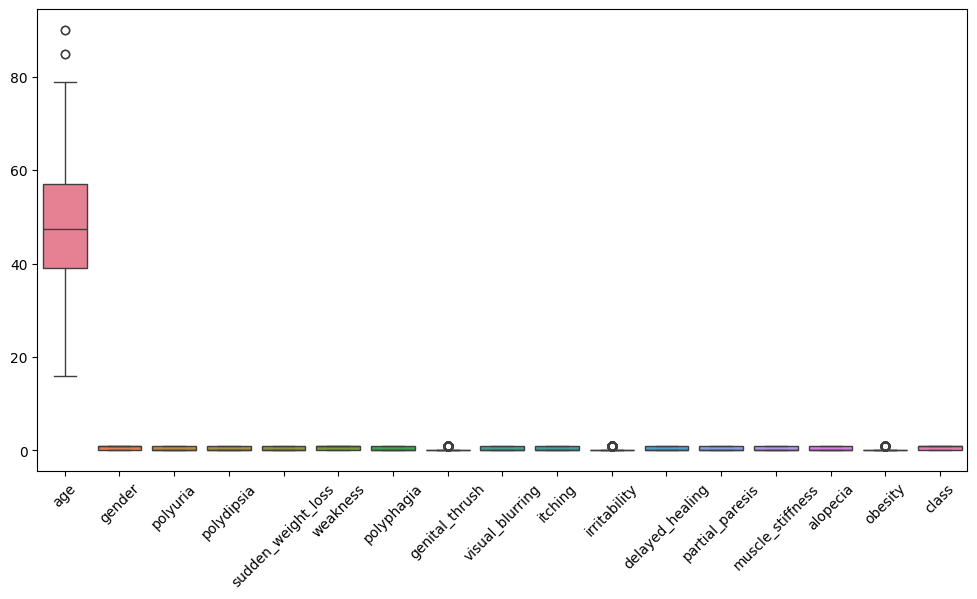

In [113]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_diabetes_early)
plt.xticks(rotation=45)
plt.show()

In [109]:
# performing train/test split

X = df_diabetes_early.drop(columns=['class'])
y = df_diabetes_early['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train['age'] = scaler.fit_transform(X_train[['age']])
X_test['age'] = scaler.transform(X_test[['age']])

In [111]:
# training with LR
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {lr_accuracy:.4f}')

Logistic Regression Accuracy: 0.9231


In [114]:
DT = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
DT.fit(X_train, y_train)
y_pred_dt = DT.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')

Decision Tree Accuracy: 0.9519


In [115]:
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

Random Forest Accuracy: 0.9904


In [117]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {gb_accuracy:.4f}')

Gradient Boosting Accuracy: 0.9712


In [118]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {svm_accuracy:.4f}')

SVM Accuracy: 0.9712


<ipython-input-273-acdf52f34dbb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])


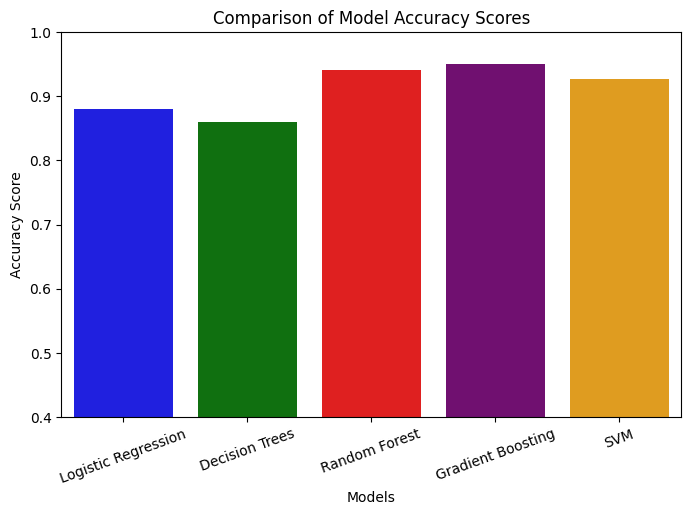

In [273]:
models = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Gradient Boosting', 'SVM']
accuracy_scores = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, svm_accuracy]  # Fixing duplicate values
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])

plt.ylim(0.4, 1.0)
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks(rotation=20)

plt.show()

## Heart Disease

In [120]:
blob_client = container_client.get_blob_client("heart_disease.csv")

# Download blob data
downloaded_blob_heart = blob_client.download_blob()
csv_data_heart = downloaded_blob_heart.readall()

# Convert to pandas DataFrame
df_heart = pd.read_csv(io.StringIO(csv_data_heart.decode('utf-8')))
print(df_heart.head(10))

    age  sex  chest-pain  rest-bp  serum-chol  fasting-blood-sugar  \
0  70.0  1.0         4.0    130.0       322.0                  0.0   
1  67.0  0.0         3.0    115.0       564.0                  0.0   
2  57.0  1.0         2.0    124.0       261.0                  0.0   
3  64.0  1.0         4.0    128.0       263.0                  0.0   
4  74.0  0.0         2.0    120.0       269.0                  0.0   
5  65.0  1.0         4.0    120.0       177.0                  0.0   
6  56.0  1.0         3.0    130.0       256.0                  1.0   
7  59.0  1.0         4.0    110.0       239.0                  0.0   
8  60.0  1.0         4.0    140.0       293.0                  0.0   
9  63.0  0.0         4.0    150.0       407.0                  0.0   

   electrocardiographic  max-heart-rate  angina  oldpeak  slope  \
0                   2.0           109.0     0.0      2.4    2.0   
1                   2.0           160.0     0.0      1.6    2.0   
2                   0.0     

In [122]:
print(df_heart.isna().sum())

age                     0
sex                     0
chest-pain              0
rest-bp                 0
serum-chol              0
fasting-blood-sugar     0
electrocardiographic    0
max-heart-rate          0
angina                  0
oldpeak                 0
slope                   0
major-vessels           0
thal                    0
heart-disease           0
dtype: int64


In [123]:
df_skew = df_heart.select_dtypes(include=['number'])
skew_values_heart = df_skew.skew().sort_values(ascending=False)
print(skew_values_heart)

fasting-blood-sugar     1.991971
oldpeak                 1.262893
major-vessels           1.209890
serum-chol              1.183721
angina                  0.728915
rest-bp                 0.722618
slope                   0.543151
thal                    0.287268
heart-disease           0.224858
electrocardiographic   -0.044703
age                    -0.163615
max-heart-rate         -0.527737
sex                    -0.765084
chest-pain             -0.878767
dtype: float64


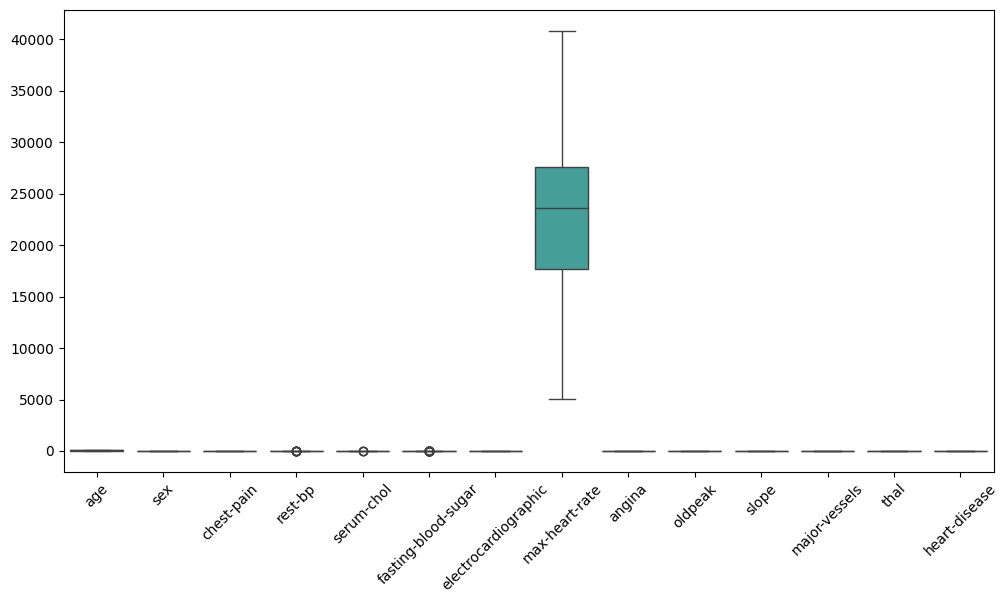

In [129]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_heart)
plt.xticks(rotation=45)
plt.show()

In [127]:
df_heart['fasting-blood-sugar'] = np.log1p(df_heart['fasting-blood-sugar'])
df_heart['oldpeak'] = np.log1p(df_heart['oldpeak'])
df_heart['major-vessels'] = np.log1p(df_heart['major-vessels'])
df_heart['serum-chol'] = np.log1p(df_heart['serum-chol'])

# Square root transformation for moderately skewed features
df_heart['angina'] = np.sqrt(df_heart['angina'])
df_heart['rest-bp'] = np.sqrt(df_heart['rest-bp'])
df_heart['slope'] = np.sqrt(df_heart['slope'])

# Power transformation for negatively skewed features
df_heart['sex'] = np.power(df_heart['sex'], 2)
df_heart['chest-pain'] = np.power(df_heart['chest-pain'], 2)
df_heart['max-heart-rate'] = np.power(df_heart['max-heart-rate'], 2)

In [132]:
# Splitting data into features (X) and target (y)
X = df_heart.drop(columns=['heart-disease'])
y = df_heart['heart-disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [133]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [134]:
#lr
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {lr_accuracy:.4f}')

Logistic Regression Accuracy: 0.8519


In [148]:
#decision trees
DT = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42)
DT.fit(X_train, y_train)
y_pred_dt = DT.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')

Decision Tree Accuracy: 0.7963


In [149]:
#rf
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

Random Forest Accuracy: 0.8148


In [155]:
#gb
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=6, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {gb_accuracy:.4f}')

Gradient Boosting Accuracy: 0.8333


In [156]:
#svm
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {svm_accuracy:.4f}')

SVM Accuracy: 0.8148


<ipython-input-275-acdf52f34dbb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])


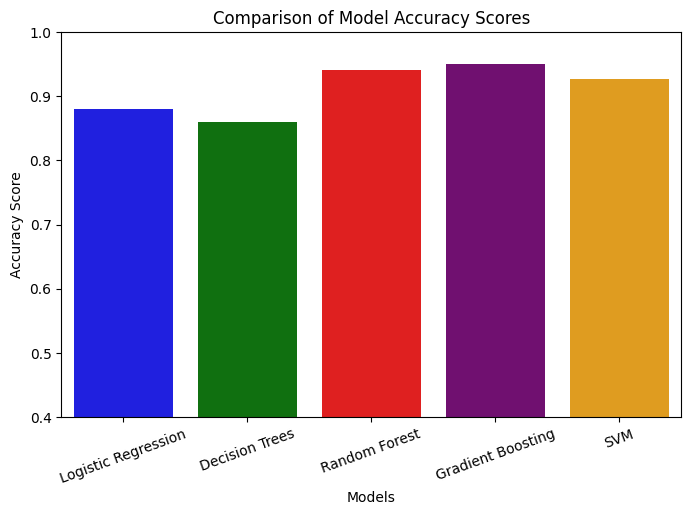

In [275]:
models = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Gradient Boosting', 'SVM']
accuracy_scores = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, svm_accuracy]  # Fixing duplicate values
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])

plt.ylim(0.4, 1.0)
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks(rotation=20)

plt.show()

##Liver

In [158]:
blob_client = container_client.get_blob_client("liver.csv")

# Download blob data
downloaded_blob_liver = blob_client.download_blob()
csv_data_liver = downloaded_blob_liver.readall()

# Convert to pandas DataFrame
df_liver = pd.read_csv(io.StringIO(csv_data_liver.decode('utf-8')))
print(df_heart.head(10))

   Class  Age  Sex  Steroid  Antivirals  Fatigue  Malaise  Anorexia  \
0      2   30    2      1.0           2      2.0      2.0       2.0   
1      2   50    1      1.0           2      1.0      2.0       2.0   
2      2   78    1      2.0           2      1.0      2.0       2.0   
3      2   31    1      NaN           1      2.0      2.0       2.0   
4      2   34    1      2.0           2      2.0      2.0       2.0   
5      2   34    1      2.0           2      2.0      2.0       2.0   
6      1   51    1      1.0           2      1.0      2.0       1.0   
7      2   23    1      2.0           2      2.0      2.0       2.0   
8      2   39    1      2.0           2      1.0      2.0       2.0   
9      2   30    1      2.0           2      2.0      2.0       2.0   

   Liver Big  Liver Firm  Spleen Palpable  Spiders  Ascites  Varices  \
0        1.0         2.0              2.0      2.0      2.0      2.0   
1        1.0         2.0              2.0      2.0      2.0      2.0   
2 

In [159]:
print(df_liver.isna().sum())

Class               0
Age                 0
Sex                 0
Steroid             1
Antivirals          0
Fatigue             1
Malaise             1
Anorexia            1
Liver Big          10
Liver Firm         11
Spleen Palpable     5
Spiders             5
Ascites             5
Varices             5
Bilirubin           6
Alk Phosphate      29
Sgot                4
Albumin            16
Protime            67
Histology           0
dtype: int64


In [162]:
categorical_cols = ['Steroid', 'Fatigue', 'Malaise', 'Anorexia', 'Liver Big', 'Liver Firm', 'Spleen Palpable', 'Spiders', 'Ascites', 'Varices']
for col in categorical_cols:
    df_liver[col].fillna(df_liver[col].mode()[0], inplace=True)

# Fill numerical missing values with median
numerical_cols = ['Bilirubin', 'Alk Phosphate', 'Sgot', 'Albumin', 'Protime']
for col in numerical_cols:
    df_liver[col].fillna(df_liver[col].median(), inplace=True)

# Drop 'Protime' if necessary (high missing values)
#df.drop(columns=['Protime'], inplace=True)


<ipython-input-162-160bae22ec33>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_liver[col].fillna(df_liver[col].mode()[0], inplace=True)
<ipython-input-162-160bae22ec33>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [163]:
print(df_liver.isna().sum())

Class              0
Age                0
Sex                0
Steroid            0
Antivirals         0
Fatigue            0
Malaise            0
Anorexia           0
Liver Big          0
Liver Firm         0
Spleen Palpable    0
Spiders            0
Ascites            0
Varices            0
Bilirubin          0
Alk Phosphate      0
Sgot               0
Albumin            0
Protime            0
Histology          0
dtype: int64


In [195]:
# Splitting data into features (X) and target (y)
X = df_liver.drop(columns=['Class'])
y = df_liver['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [196]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [197]:
#lr
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {lr_accuracy:.4f}')

Logistic Regression Accuracy: 0.8718


In [207]:
#decision trees
DT = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
DT.fit(X_train, y_train)
y_pred_dt = DT.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')

Decision Tree Accuracy: 0.8205


In [205]:
#rf
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

Random Forest Accuracy: 0.8205


In [202]:
#gb
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {gb_accuracy:.4f}')

Gradient Boosting Accuracy: 0.8718


In [201]:
#svm
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {svm_accuracy:.4f}')

SVM Accuracy: 0.8462


<ipython-input-276-acdf52f34dbb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])


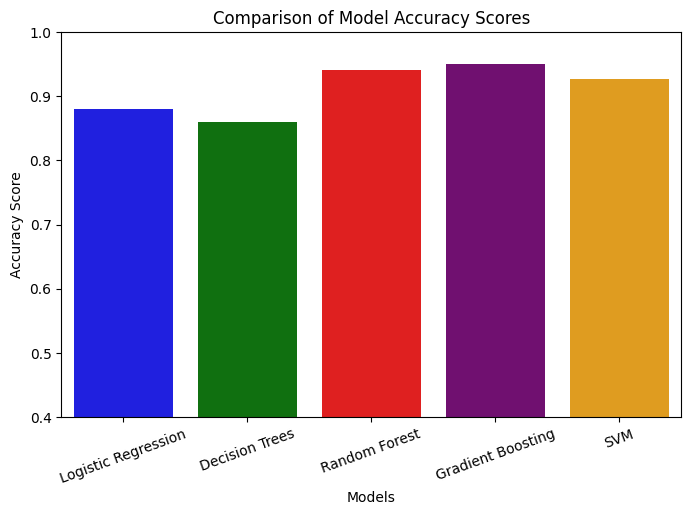

In [276]:
models = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Gradient Boosting', 'SVM']
accuracy_scores = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, svm_accuracy]  # Fixing duplicate values
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])

plt.ylim(0.4, 1.0)
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks(rotation=20)

plt.show()

## Maternal Health

In [213]:
blob_client = container_client.get_blob_client("maternal_health_risk.csv")

# Download blob data
downloaded_blob_mh = blob_client.download_blob()
csv_data_mh = downloaded_blob_mh.readall()

# Convert to pandas DataFrame
df_mh = pd.read_csv(io.StringIO(csv_data_mh.decode('utf-8')))
print(df_mh.head(10))

   Age  SystolicBP  DiastolicBP     BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.00      98.0         86  high risk
1   35         140           90  13.00      98.0         70  high risk
2   29          90           70   8.00     100.0         80  high risk
3   30         140           85   7.00      98.0         70  high risk
4   35         120           60   6.10      98.0         76   low risk
5   23         140           80   7.01      98.0         70  high risk
6   23         130           70   7.01      98.0         78   mid risk
7   35          85           60  11.00     102.0         86  high risk
8   32         120           90   6.90      98.0         70   mid risk
9   42         130           80  18.00      98.0         70  high risk


In [214]:
print(df_mh.isna().sum())

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [215]:
df_skew = df_mh.select_dtypes(include=['number'])
skew_values_mh = df_skew.skew().sort_values(ascending=False)
print(skew_values_mh)

BS             1.868203
BodyTemp       1.750988
Age            0.783063
DiastolicBP   -0.048441
SystolicBP    -0.251189
HeartRate     -1.043525
dtype: float64


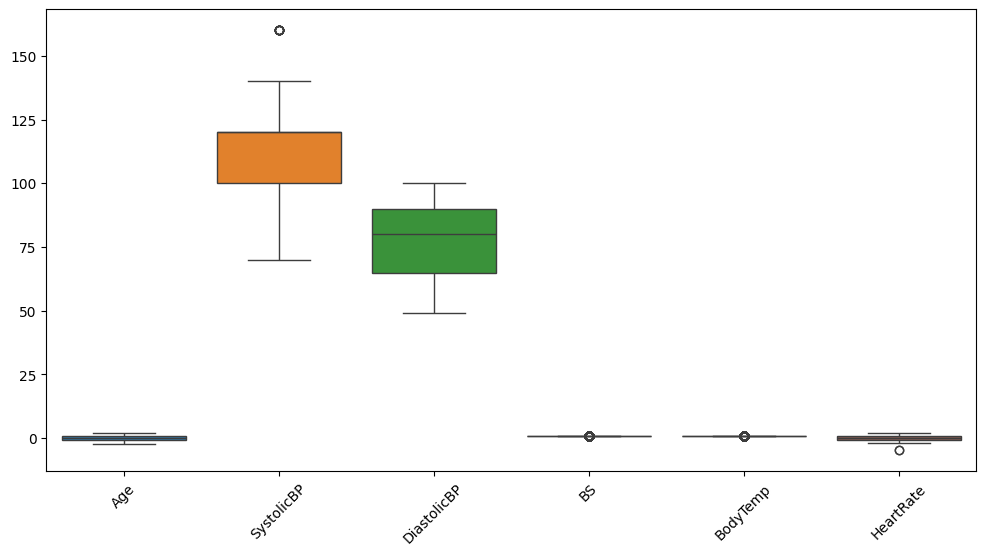

In [221]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_mh)
plt.xticks(rotation=45)
plt.show()

In [219]:
df_mh['BS'] = np.log1p(df_mh['BS'])
df_mh['BodyTemp'] = np.log1p(df_mh['BodyTemp'])

scaler = PowerTransformer()
scaled_features = scaler.fit_transform(df_mh[['Age', 'HeartRate']])
df_mh[['Age', 'HeartRate']] = scaled_features

In [224]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_mh['RiskLevel'] = label_encoder.fit_transform(df_mh['RiskLevel'])
print(df_mh.head(10))

        Age  SystolicBP  DiastolicBP        BS  BodyTemp  HeartRate  RiskLevel
0 -0.153700         130           80  0.844907  1.001328   1.574614          0
1  0.601410         140           90  0.829305  1.001328  -0.597093          0
2  0.183614          90           70  0.771165  1.002638   0.706757          0
3  0.259732         140           85  0.753653  1.001328  -0.597093          0
4  0.601410         120           60  0.734875  1.001328   0.163864          1
5 -0.346063         140           80  0.753844  1.001328  -0.597093          0
6 -0.346063         130           70  0.753844  1.001328   0.431747          2
7  0.601410          85           60  0.810237  1.003917   1.574614          0
8  0.403670         120           90  0.751725  1.001328  -0.597093          2
9  0.996041         130           80  0.863863  1.001328  -0.597093          0


In [243]:
X = df_mh.drop(columns=['RiskLevel'])
y = df_mh['RiskLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [244]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [245]:
#lr
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {lr_accuracy:.4f}')

Logistic Regression Accuracy: 0.6535


In [246]:
#dt
DT = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
DT.fit(X_train, y_train)
y_pred_dt = DT.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')

Decision Tree Accuracy: 0.6811


In [247]:
#rf
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

Random Forest Accuracy: 0.8740


In [248]:
#gb
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {gb_accuracy:.4f}')

Gradient Boosting Accuracy: 0.8583


In [249]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {svm_accuracy:.4f}')

SVM Accuracy: 0.7126


<ipython-input-277-acdf52f34dbb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])


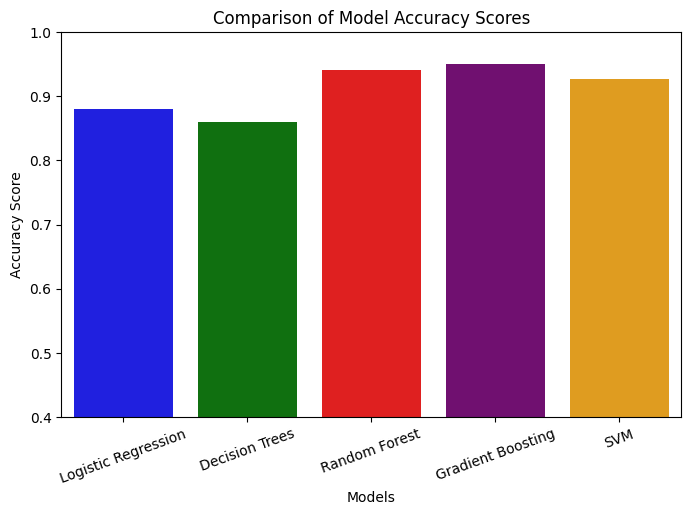

In [277]:
models = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Gradient Boosting', 'SVM']
accuracy_scores = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, svm_accuracy]  # Fixing duplicate values
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])

plt.ylim(0.4, 1.0)
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks(rotation=20)

plt.show()

## Obesity

In [256]:
blob_client = container_client.get_blob_client("obesity.csv")

# Download blob data
downloaded_blob_ob = blob_client.download_blob()
csv_data_ob = downloaded_blob_ob.readall()

# Convert to pandas DataFrame
df_ob = pd.read_csv(io.StringIO(csv_data_ob.decode('utf-8')))
print(df_ob.head(10))

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   
5    Male  29.0    1.62    53.0                             no  yes   2.0   
6  Female  23.0    1.50    55.0                            yes  yes   3.0   
7    Male  22.0    1.64    53.0                             no   no   2.0   
8    Male  24.0    1.78    64.0                            yes  yes   3.0   
9    Male  22.0    1.72    68.0                            yes  yes   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  y

In [257]:
print(df_ob.isna().sum())

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [258]:
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
df_ob = pd.get_dummies(df_ob, columns=categorical_cols, drop_first=True)
#encodong target
label_encoder = LabelEncoder()
df_ob['NObeyesdad'] = label_encoder.fit_transform(df_ob['NObeyesdad'])

numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
scaler = StandardScaler()
df_ob[numerical_cols] = scaler.fit_transform(df_ob[numerical_cols])

In [260]:
X = df_ob.drop(columns=['NObeyesdad'])
y = df_ob['NObeyesdad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [261]:
#lr
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {lr_accuracy:.4f}')

Logistic Regression Accuracy: 0.8807


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [266]:
#dt
DT = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=42)
DT.fit(X_train, y_train)
y_pred_dt = DT.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')

Decision Tree Accuracy: 0.8598


In [267]:
#rf
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

Random Forest Accuracy: 0.9413


In [268]:
#gb
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {gb_accuracy:.4f}')

Gradient Boosting Accuracy: 0.9508


In [269]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {svm_accuracy:.4f}')

SVM Accuracy: 0.9261


<ipython-input-278-acdf52f34dbb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])


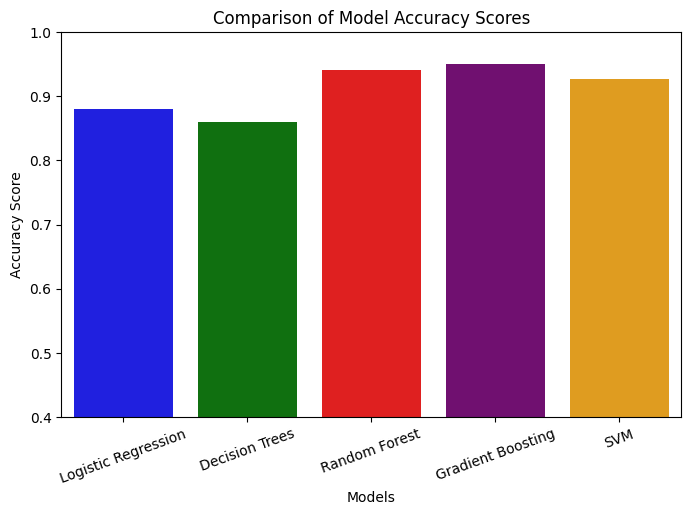

In [278]:
models = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Gradient Boosting', 'SVM']
accuracy_scores = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, svm_accuracy]  # Fixing duplicate values
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy_scores, palette=['blue', 'green', 'red', 'purple', 'orange'])

plt.ylim(0.4, 1.0)
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracy Scores")
plt.xticks(rotation=20)

plt.show()